In [1]:
DF_PATH       = "../data/processed/1_preprocessed_df.pkl"
FEATURES_PATH = "../data/processed/features_skills_clusters.pkl"

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageWorkedWith',    'DatabaseWorkedWith',    'WebframeWorkedWith',    'MiscTechWorkedWith']

EXPORT_PATH    = "../data/processed/2_cleaned_data.pkl"

In [2]:
# Load packages
import pandas as pd 
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

### Read data and preprocess

In [3]:
# Read Data 
processed_df = pd.read_pickle(DF_PATH)
features_df = pd.read_pickle(FEATURES_PATH)

In [14]:
processed_df["DevType"]

0        [Developer, desktop or enterprise applications...
1               [Developer, full-stack, Developer, mobile]
2                                                       []
3                                                       []
4                                                       []
                               ...                        
64456                                [Senior executive/VP]
64457                                                   []
64458                                                   []
64459                                                   []
64460                                                   []
Name: DevType, Length: 64461, dtype: object

In [4]:
# One hot encode 
encoded_dfs = {}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(processed_df[col]),
                               columns=binarizer.classes_,
                               index=processed_df[col].index)
    encoded_dfs[col] = encoded_df
    
# Merge 1-hot encoded 
encoded_dfs = pd.concat(encoded_dfs, axis=1)

### Quick sanity check

In [12]:
# Select random int
i = np.random.randint(processed_df.shape[0])

# Print original values
print(processed_df.iloc[i][ROLE_COLS].tolist())
print(processed_df.iloc[i][TECH_COLS].tolist())
print("----------------")

# Print processed
print(encoded_dfs.iloc[i][encoded_dfs.iloc[i] == 1])
print("----------------")

# Check clustering 
print("Clusters:",features_df.iloc[i].sum())
print("Skills:",  encoded_dfs[TECH_COLS].iloc[i].sum())

[['Developer, back-end', 'Developer, desktop or enterprise applications']]
[['C#'], ['Microsoft SQL Server'], [], ['.NET', '.NET Core']]
----------------
DevType             Developer, back-end                              1
                    Developer, desktop or enterprise applications    1
LanguageWorkedWith  C#                                               1
DatabaseWorkedWith  Microsoft SQL Server                             1
MiscTechWorkedWith  .NET                                             1
                    .NET Core                                        1
Name: 27440, dtype: int64
----------------
Clusters: 4
Skills: 4


___________

## Exclude Roles

In [6]:
# Exclude roles
EXCULDE_ROLES = ['Designer', 'Educator', 'Marketing or sales professional', 'Engineering manager',
                 'Product manager', 'Senior executive/VP', "Engineer, site reliability"]

for role in EXCULDE_ROLES:
    encoded_dfs = encoded_dfs.drop(("DevType", role), axis=1)

___________

## Filter data

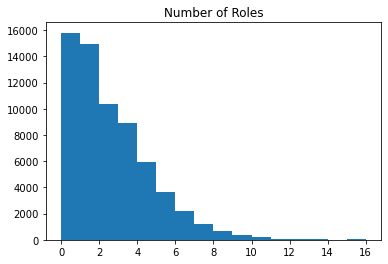

In [7]:
freq_roles = encoded_dfs[ROLE_COLS].sum(axis=1)
plt.hist(freq_roles, freq_roles.max())
plt.title('Number of Roles')
plt.show()

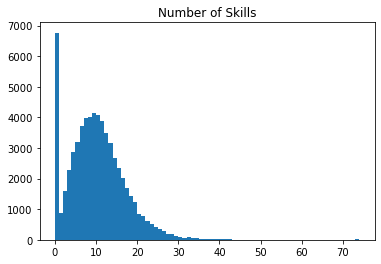

In [8]:
freq_tech = encoded_dfs[TECH_COLS].sum(axis=1)
plt.hist(freq_tech, freq_tech.max())
plt.title('Number of Skills')
plt.show()

In [9]:
# Filter frequencies 
ROLES_RANGE = [1,2]
TECH_RANGE  = [3,12]

In [10]:
# Create masks 
role_mask   = (freq_roles >= ROLES_RANGE[0]) & (freq_roles <= ROLES_RANGE[1])
tech_mask   = (freq_tech >= TECH_RANGE[0])   & (freq_tech <= TECH_RANGE[1])
filter_mask = role_mask & tech_mask

In [11]:
features_df = features_df.loc[filter_mask].copy()
encoded_dfs = encoded_dfs.loc[filter_mask].copy()

__________

### Merge & Export data

In [12]:
# Add second level indexing 
features_df.columns = pd.MultiIndex.from_product([['skills_clusters'], 
                                                  features_df.columns])

In [13]:
# Concatenate
df = pd.concat([encoded_dfs, features_df], axis=1)

In [14]:
# Export 
df.to_pickle(EXPORT_PATH)